In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit
using Plots, LaTeXStrings
using DelimitedFiles
using DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
function print_fit_values(fit, par0, par_names, alpha=0.1)
    println(@sprintf "RSS = %.5f (convergence: %s)" sum(abs2, fit.resid) fit.converged)
    for i in 1:length(par0)
        name = par_names[i]
        val = fit.param[i]
        CIl = confidence_interval(fit, alpha)[i][1]
        CIr = confidence_interval(fit, alpha)[i][2]
        p0 = par0[i]
        println(@sprintf "  %s = %.3e (CI=(%.3e, %.3e), initial=%.3e)" name val CIl CIr p0)
    end
end

print_fit_values (generic function with 2 methods)

# Viral load data fitting

Data for influenza from

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


## Data set

10 mice with 13 data points each

In [4]:
tdata = Array(range(0, 12 , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4.18551,5.67816,6.00515,5.9364,5.97712,5.44716,5.19848,4.00515,0.0,0.0,0.0,0.0
2,0.0,3.99136,5.47712,5.84488,5.82436,5.81012,5.0874,4.49136,0.0,0.0,0.0,0.0,0.0
3,0.0,3.49136,5.44716,5.81012,5.83815,5.78016,5.2954,5.01851,2.94716,0.0,0.0,0.0,0.0
4,0.0,3.29788,5.77233,6.24612,5.49136,5.9624,5.14412,5.51851,3.23882,0.0,0.0,0.0,0.0
5,0.0,4.75515,5.9624,6.44716,5.78016,5.83244,5.99136,4.96982,0.0,0.0,0.0,0.0,0.0
6,0.0,4.30151,5.49136,6.86448,5.70812,5.80282,4.9624,4.47712,0.0,0.0,0.0,0.0,0.0
7,0.0,3.49136,5.7954,5.74951,6.03148,5.82436,5.2954,5.17215,3.26036,0.0,0.0,0.0,0.0
8,0.0,4.00515,6.03148,5.83815,6.26036,6.1294,5.18551,4.83815,0.0,0.0,0.0,0.0,0.0
9,0.0,3.49136,6.18551,5.78784,5.59921,5.97712,5.34488,5.47712,0.0,0.0,0.0,0.0,0.0


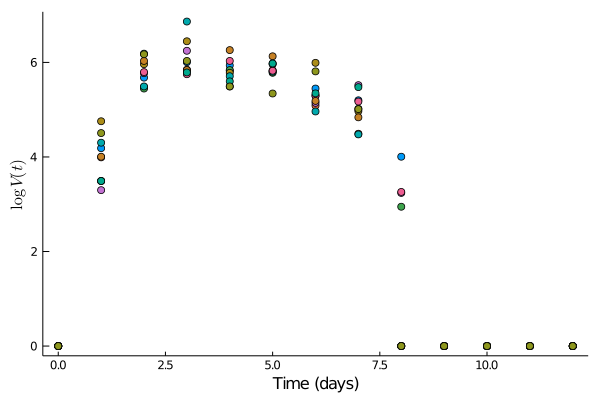

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

### Average of data

In [6]:
vdata_avg = mean(data, dims=1)[:]
vdata_std = std(data, dims=1)[:];

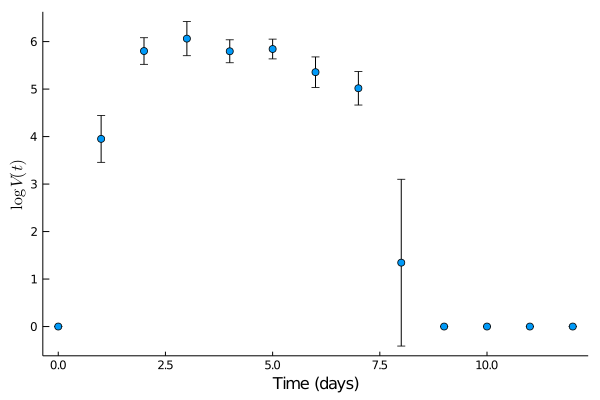

In [7]:
plot(tdata, vdata_avg, yerrors=vdata_std,
    seriestype=:scatter, legend=:none, grid=:off,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data

In [8]:
ttdata = reshape(repeat(tdata', 10), 1, :)[:]
vvdata = reshape(data, 1, :)[:];

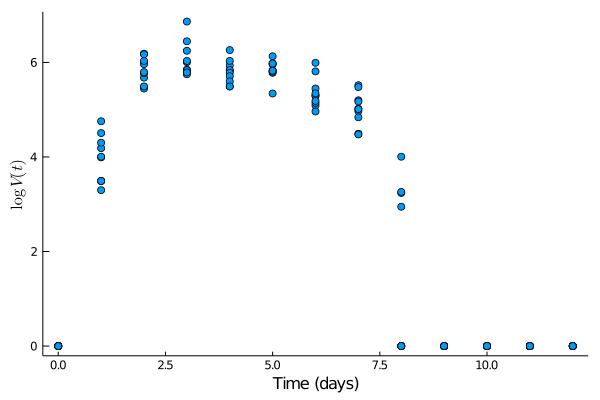

In [9]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

### Combined data omitting last 3 observations

In [10]:
ttdata = reshape(repeat(tdata[1:end-3]', 10), 1, :)[:]
tend = ttdata[end]
vvdata = reshape(data[:, 1:end-3], 1, :)[:];

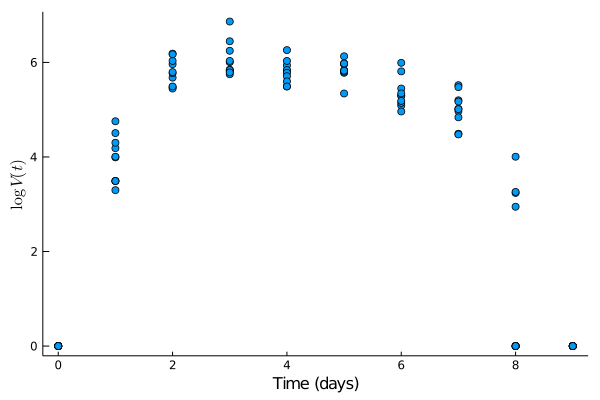

In [11]:
plot(ttdata, vvdata, 
    seriestype=:scatter, legend=:none, grid=:none,
    xlabel="Time (days)", ylabel=L"\log\,V(t)")

We'll use the combined data. But the average data shows similar results.

## ODE Model


The standard viral kinetic model with varying clearance rate reads
$$
\begin{aligned}
\frac{dT}{dt} & = -\beta T V, \\
\frac{dI_1}{dt} & = \beta T V - k I_1, \\
\frac{dI_2}{dt} & = k I_1 - \frac{\delta I_2}{K + I_2}, \\
\frac{dV}{dt} & = p I_2 -c V.
\end{aligned}
$$

*Smith, A. P., Moquin, D. J., Bernhauerova, V., & Smith, A. M. (2018). Influenza virus infection model with density dependence supports biphasic viral decay. Frontiers in Microbiology, 9(JUL), 1–10. https://doi.org/10.3389/fmicb.2018.01554*


In [12]:
ViralTarget = @ode_def begin
    dT = -β*T*V
    dI₁ = β*T*V - k*I₁
    dI₂ = k*I₁ - δ*I₂/(K + I₂)
    dV = p*I₂ - c*V
end β k δ K p c;

In [37]:
u0 = [1e+7, 75.0, 0.0, 1e0]
tspan = (0.0, tend)
pars = (β = 2.629e-04,
        k = 1.480e+00,
        δ = 1.593e+06,
        K = 7.899e+04,
        p = 2.090e+00,
        c = 1.505e+01)
par_names = keys(pars)
prob = ODEProblem(ViralTarget, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 9.0)
u0: [1.0e7, 75.0, 0.0, 1.0]

In [14]:
sol = solve(prob, Tsit5(); dtmax=1e-2);

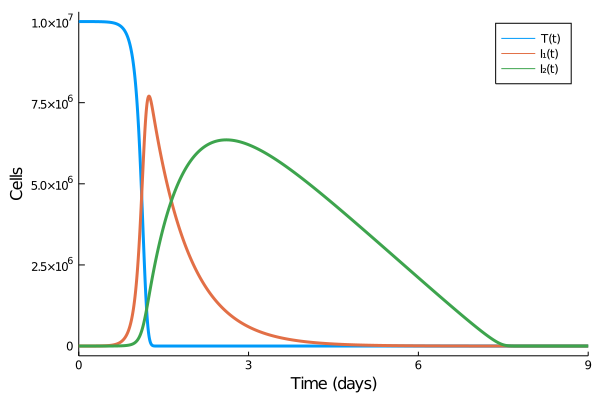

In [15]:
plot(sol, vars=(1:3), lw=3, xlabel="Time (days)", ylabel="Cells", grid=:off)

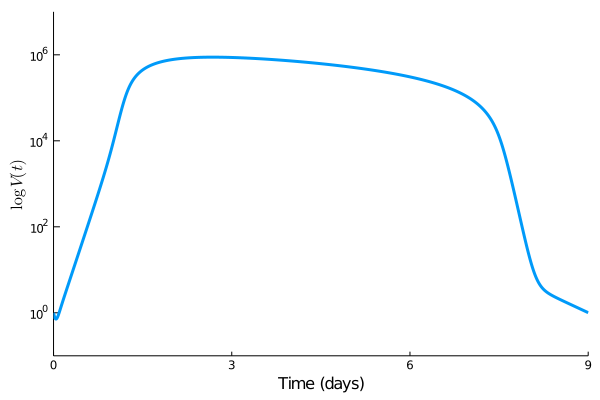

In [16]:
plot(sol, vars=(4), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (1e-1, 1e+7), :log10))

### Fitting the ODE model to data

Only $V$ in logarithmic scale to fit the model.

In [32]:
function model(t, p)
    pars = (β = p[1],
            k = p[2],
            δ = p[3],
            K = p[4],
            p = p[5],
            c = p[6])
    prob = ODEProblem(ViralTarget, u0, tspan, pars)
    sol = solve(prob, Tsit5(), dtmax=1e-2)
    log10.(sol(t)[end, :])
end

model (generic function with 1 method)

In [33]:
par0 = [2.5e-4,
        1.5,
        1.6e+6,
        5e+4,
        2.1,
        15.0]
lb = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ub = [Inf, Inf, Inf, Inf, Inf, Inf]
fit = curve_fit(model, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.0002629436343203911, 1.4803307516958601, 1.5931696621343181e6, 78989.80860506534, 2.0900683301459613, 15.048219517262918], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445, 0.0018526271146521445], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -1687.5804713093214 -3.335046242304353 … 0.014380849542030505 -0.01498715242430151; -1687.5804713093214 -3.335046242304353 … 0.014380849542030505 -0.01498715242430151], true, Float64[])

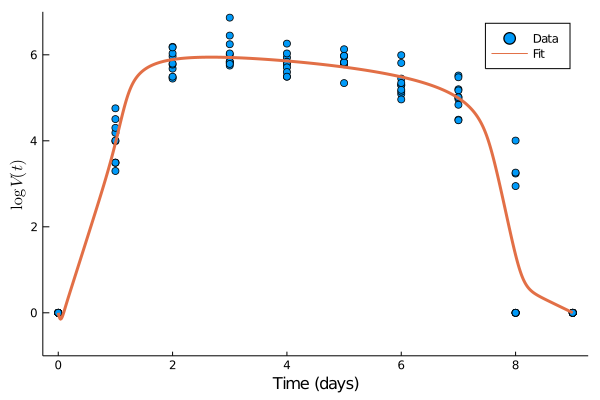

In [34]:
pt = plot(ttdata, vvdata, seriestype=:scatter, label="Data")
tt = [range(0., tend, step=1e-2);]
plot!(pt, tt, model(tt, fit.param), lw=3, 
    label="Fit", grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))
savefig(figdir*"Smith2018ODEDataFit.png")
savefig(figdir*"Smith2018ODEDataFit.pdf")
display(pt)

In [38]:
print_fit_values(fit, par0, par_names, 0.05)

RSS = 35.39628 (convergence: true)
  β = 2.629e-04 (CI=(-4.546e-03, 5.072e-03), initial=2.500e-04)
  k = 1.480e+00 (CI=(-1.326e+00, 4.287e+00), initial=1.500e+00)
  δ = 1.593e+06 (CI=(6.488e+05, 2.538e+06), initial=1.600e+06)
  K = 7.899e+04 (CI=(-1.390e+06, 1.548e+06), initial=5.000e+04)
  p = 2.090e+00 (CI=(-2.864e+01, 3.282e+01), initial=2.100e+00)
  c = 1.505e+01 (CI=(-2.122e+02, 2.423e+02), initial=1.500e+01)


Standard errors are really high, although the convergence was true.

Also, there is a blip at $t=0$, possibly caused by the choice of initial contitions.

### Using initial conditions close to Smith's best fit

We have issues with some parameters going to negative values (a quick debugguing shows $k$ becomes negative in this case), leading to negative solutions.

**Note: this seems to be an issue with `LsqFit.jl` since one of the parameters falls outside of the retrictions ($k\geq 0$ in this case). Bug?**

In [39]:
par0 = [9.9e-5,
        4.0,
        1.65e+6,
        1.134e+5,
        1.7,
        12.48]
lb = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ub = [Inf, Inf, Inf, Inf, Inf, Inf]
fit = curve_fit(model, ttdata, vvdata, par0, lower=lb, upper=ub)

DomainError: DomainError with -4.766939687987622e-5:
NaN result for non-NaN input.

A quick fix is to modify the constrain box to restrict the minimum value of $k$ a little far from zero. (Alternatively, we could start from randomly genereted initial conditions and keep only true convergence results.)

In [40]:
par0 = [9.9e-5,
        4.0,
        1.65e+6,
        1.134e+5,
        1.7,
        12.48]
lb = [0.0, 0.6, 0.0, 0.0, 0.0, 0.0]
ub = [Inf, Inf, Inf, Inf, Inf, Inf]
fit = curve_fit(model, ttdata, vvdata, par0, lower=lb, upper=ub)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([0.00024141343342025815, 1.492986786602247, 1.5979549350329738e6, 85846.49181752357, 2.2556889423256092, 16.251044256941533], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885, 0.001934658919853885], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -1863.6381173396478 -3.3363918723578903 … 0.009728663720249683 -0.012924339176692026; -1863.6381173396478 -3.3363918723578903 … 0.009728663720249683 -0.012924339176692026], true, Float64[])

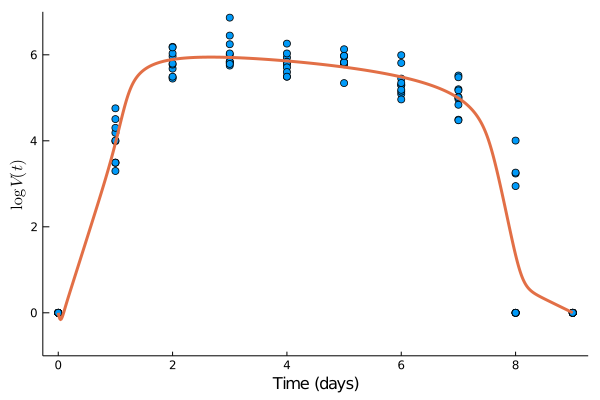

In [41]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
plot!(tt, model(tt, fit.param), lw=3, legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

In [42]:
print_fit_values(fit, par0, par_names, 0.05)

RSS = 35.39647 (convergence: true)
  β = 2.414e-04 (CI=(-4.228e-03, 4.711e-03), initial=9.900e-05)
  k = 1.493e+00 (CI=(-9.547e-01, 3.941e+00), initial=4.000e+00)
  δ = 1.598e+06 (CI=(7.426e+05, 2.453e+06), initial=1.650e+06)
  K = 8.585e+04 (CI=(-1.320e+06, 1.491e+06), initial=1.134e+05)
  p = 2.256e+00 (CI=(-4.439e+01, 4.890e+01), initial=1.700e+00)
  c = 1.625e+01 (CI=(-3.255e+02, 3.580e+02), initial=1.248e+01)
